In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.utils.multiclass import unique_labels

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
# print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

In [2]:
#Import standard libraries

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
''' to learn more about itertools visit
    https://medium.com/@jasonrigden/a-guide-to-python-itertools-82e5a306cdf8'''
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [3]:
#Import keras functions

from tensorflow.keras import Sequential

'''Since we are using transfer learning let's import the model that we want to implement.Let's use VGG 19(19 layers) and Resnet-50 (50 layers of residual units). 
Residual units allow us to add more layers onto the model without a degradation in accuracy.
Let's try and compare the accuracy of the 2 models and see if the addtional layers do make a significant difference. '''

from tensorflow.keras.applications import VGG19,ResNet50

'Import the datagenerator to augment images'
from tensorflow.keras.preprocessing.image import ImageDataGenerator

'''Import the optimizers and leanring rate annealer (which will reduce the learning rate once a particular metric we choose(in this case validation error) 
does not reduce after a user defined number of epochs)'''
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

'Lastly import the final layers that will be added on top of the base model'
from tensorflow.keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout

'Import to_categorical from the keras utils package to one hot encode the labels'
from tensorflow.keras.utils import to_categorical

In [4]:
#Import dataset
from tensorflow.keras.datasets import cifar10

In [5]:
#Divide the data in Train, Validation and Test Datasets
'I had to turn the Internet setting to on to download load the dataset'
(x_train,y_train),(x_test,y_test)=cifar10.load_data()

In [6]:
y_train=to_categorical(y_train)
#y_val=to_categorical(y_val)
y_test=to_categorical(y_test)

In [7]:
# Lets print the dimensions one more time to see if things changed the way we expected

print((x_train.shape,y_train.shape))
#print((x_val.shape,y_val.shape))
print((x_test.shape,y_test.shape))

((50000, 32, 32, 3), (50000, 10))
((10000, 32, 32, 3), (10000, 10))


We can now begin the actual process of model building.I find that following a set process and following consistently makes learning this easier.So here is the process I follow:

- Define the Data Augmentation (ImageDataGenerator) and Learning Rate Annealer (ReduceOnPlateau) functions
- Build the model (Base Model + Flatten + Dense)
- Check model summary
- Initialize Batch Size,Number of Epochs
- Compile model
- Fit the model (We will use fit_generator since the data is fed to the model using an augmentation function
- Evaluate the model on test data

In [8]:
#Data Augmentation Function: Let's define an instance of the ImageDataGenerator class and set the parameters.We have to instantiate for the Train,Validation and Test datasets
train_generator = ImageDataGenerator(
                                    rotation_range=2, 
                                    horizontal_flip=True,
                                    zoom_range=.1 )

#val_generator = ImageDataGenerator(
#                                    rotation_range=2, 
#                                    horizontal_flip=True,
#                                    zoom_range=.1)

test_generator = ImageDataGenerator(
                                    rotation_range=2, 
                                    horizontal_flip= True,
                                    zoom_range=.1) 

In [9]:
#Fit the augmentation method to the data

train_generator.fit(x_train)
#val_generator.fit(x_val)
test_generator.fit(x_test)

It's not necessary to use a data generator for validation data while fitting the model, however I find that it gives better validation accuracy if it is used.This is probably because themodel can learn more generalized features if validation data is also augmented. Ive used only a few of the many available functionalities of the augment function.To know more about the capabilities read this article: https://towardsdatascience.com/image-augmentation-for-deep-learning-using-keras-and-histogram-equalization-9329f6ae5085

In [10]:
'''Learning Rate Annealer: The learning rate can be modified after a set number of epochs or after a certain condition is met. We will use the latter and change the learning rate if 
the validation error does not reduce after a set number of epochs. To do this we will use the patience parameter.'''

lrr= ReduceLROnPlateau(
                       monitor='val_acc', #Metric to be measured
                       factor=.01, #Factor by which learning rate will be reduced
                       patience=3,  #No. of epochs after which if there is no improvement in the val_acc, the learning rate is reduced
                       min_lr=1e-5) #The minimum learning rate 

In [11]:
#Build the model

'The first base model used is VGG19. The pretrained weights from the imagenet challenge are used'
base_model_1 = VGG19(include_top=False,weights='imagenet',input_shape=(32,32,3),classes=y_train.shape[1])

'For the 2nd base model we will use Resnet 50 and compare the performance against the previous one.The hypothesis is that Resnet 50 should perform better because of its deeper architecture'
base_model_2 = ResNet50(include_top=False,weights='imagenet',input_shape=(32,32,3),classes=y_train.shape[1])

In [12]:
#Lets add the final layers to these base models where the actual classification is done in the dense layers

model_1= Sequential()
model_1.add(base_model_1) #Adds the base model (in this case vgg19 to model_1)
model_1.add(Flatten()) #Since the output before the flatten layer is a matrix we have to use this function to get a vector of the form nX1 to feed it into the fully connected layers

Before we add the dense layers we must know the shape of the output of the flatten layer so we can define the input shape to the dense layer accordingly. The way I handle is I print the summary of the model after the flatten layer is added.

In [13]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 1, 1, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
Total params: 20,024,384
Trainable params: 20,024,384
Non-trainable params: 0
_________________________________________________________________


So after the flatten layer we see the output to be a vector of (512,1).This will help in deciding the number of neurons in the dense layer following the flatten layer.

In [14]:
#Add the Dense layers along with activation and batch normalization
model_1.add(Dense(1024,activation=('relu'),input_dim=512))
model_1.add(Dense(512,activation=('relu'))) 
model_1.add(Dense(256,activation=('relu'))) 
#model_1.add(Dropout(.3))#Adding a dropout layer that will randomly drop 30% of the weights
model_1.add(Dense(128,activation=('relu')))
#model_1.add(Dropout(.2))
model_1.add(Dense(10,activation=('softmax'))) #This is the classification layer

In [15]:
#Check final model summary
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 1, 1, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1024)              525312    
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1

After checking the model summary, let's initialize the batchsize and number of epochs.You can leave the batch unspecified and it defaults to 32. Batch size is the number of samples over which the gradient is calculated. An epoch is just the number of times the entire dateset is passed through the network.

As a rule of thumb, as the batch size increases, the accuracy over each epoch SHOULD increase faster than if the batch size were smaller. This makes sense since we are training the model over more samples over each step. Therefore the number of epochs required to converge to a solution SHOULD THEORETICALLY be less.

A lot of selection parameters have to do with the size and shape of training data. Since our training data set has 35K samples, we can choose a larger batch size.

In [27]:
batch_size= 32
epochs=50

The next step is to define the learning rate for the optimizer we will use. I have chosen the SGD and Adam optimizer. The main difference between the 2 is that SGD uses the same learning rate for all parameters and updates all of them by the same amount. The learning rate does not change during training. Adam stands for Adaptive Moment estimation and maintains a separate learning rate for each parameter and updates them separately.

To understand this concept more please read this article: https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/

In [17]:
learn_rate=.001

sgd=SGD(lr=learn_rate,momentum=.9,nesterov=False)
adam=Adam(lr=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

This is the official Keras documentation page on Optimizers.Since the choice o optimizer has a lot of influence on model performance, I'd reccomend giving it a read

https://keras.io/optimizers/

In [18]:
#Compile the model
#During model compiling the 3 main things we specify are loss function,optimizer and the metrics that need to be evaluated during the test and train processes.
#Lets start by using the SGD optimizer
#We will specify the loss as categoricl crossentropy since the labels are 1 hot encoded. IF we had integer labels,we'd have to use sparse categorical crossentropy as loss function.
model_1.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])

Now comes the fun part: Model Training. Since we're using a function to generate data, we have to use the argument fit_generator. Both the train data and the validation data will be generated using the augmentation methods we have previously defined. To use the fit_generator function we will define the following parameters:

generator.flow(x_train,y_train,batch_size)

Here we use generator.flow since the data is being generated from a numpy array. You could also have data available in folders in which case we would use flow_from_directory in which case the class names are inferred directly from the folder names within the train data folder

More information on this can be found by reading the official documentation: https://keras.io/preprocessing/image/

In [20]:
model_1.fit_generator(train_generator.flow(x_train,y_train,batch_size=batch_size),
                      epochs=epochs,
                      steps_per_epoch=x_train.shape[0]//batch_size,
                      validation_data=test_generator.flow(x_test,y_test,batch_size=batch_size),
                      callbacks=[lrr],verbose=1)

/store/travail/opmos/conda/envs/tf-gpu/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
500/500 [==============================] - 56s 104ms/step - loss: 2.4098 - accuracy: 0.1173 - val_loss: 2.1592 - val_accuracy: 0.1891
Epoch 2/50
500/500 [==============================] - 51s 102ms/step - loss: 2.1041 - accuracy: 0.2001 - val_loss: 1.9582 - val_accuracy: 0.2341
Epoch 3/50
500/500 [==============================] - 51s 103ms/step - loss: 1.6728 - accuracy: 0.3790 - val_loss: 1.1289 - val_accuracy: 0.6109
Epoch 4/50
500/500 [==============================] - 51s 102ms/step - loss: 0.9155 - accuracy: 0.6873 - val_loss: 0.7461 - val_accuracy: 0.7471
Epoch 5/50
500/500 [==============================] - 51s 102ms/step - loss: 0.6768 - accuracy: 0.7725 - val_loss: 0.6735 - val_accuracy: 0.7732
Epoch 6/50
500/500 [==============================] - 51s 102ms/step - loss: 0.5832 - accuracy: 0.7998 - val_loss: 0.6032 - val_accuracy: 0.7946
Epoch 7/50
500/500 [==============================] - 51s 102ms/step - loss: 0.5105 - accuracy: 0.8258 - val_loss: 0.5552 - val_ac

Epoch 28/50
500/500 [==============================] - 51s 102ms/step - loss: 0.0643 - accuracy: 0.9786 - val_loss: 0.5903 - val_accuracy: 0.8587
Epoch 29/50
500/500 [==============================] - 51s 102ms/step - loss: 0.0542 - accuracy: 0.9826 - val_loss: 0.6629 - val_accuracy: 0.8504
Epoch 30/50
500/500 [==============================] - 51s 101ms/step - loss: 0.0595 - accuracy: 0.9794 - val_loss: 0.6324 - val_accuracy: 0.8485
Epoch 31/50
500/500 [==============================] - 51s 101ms/step - loss: 0.0583 - accuracy: 0.9799 - val_loss: 0.6210 - val_accuracy: 0.8591
Epoch 32/50
500/500 [==============================] - 51s 101ms/step - loss: 0.0505 - accuracy: 0.9832 - val_loss: 0.6069 - val_accuracy: 0.8609
Epoch 33/50
500/500 [==============================] - 51s 101ms/step - loss: 0.0401 - accuracy: 0.9864 - val_loss: 0.6560 - val_accuracy: 0.8600
Epoch 34/50
500/500 [==============================] - 51s 101ms/step - loss: 0.0489 - accuracy: 0.9835 - val_loss: 0.6496 -

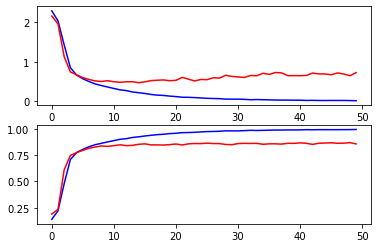

In [22]:
#Plot the training and valiation loss
'''The output of model.fit is a model.History object which is a record of metrics at each epoch. This can be used to graph the training and validation accuracy
to see where they plateaued off and if overfitting can subsequently be avoided'''

f,ax=plt.subplots(2,1) #Creates 2 subplots under 1 column

#Assign the first subplot to graph training loss and validation loss
ax[0].plot(model_1.history.history['loss'],color='b',label='Training Loss')
ax[0].plot(model_1.history.history['val_loss'],color='r',label='Validation Loss')

#Next lets plot the training accuracy and validation accuracy
ax[1].plot(model_1.history.history['accuracy'],color='b',label='Training  Accuracy')
ax[1].plot(model_1.history.history['val_accuracy'],color='r',label='Validation Accuracy')

In [19]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import time

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

In [20]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.cifar10.load_data()

In [21]:
CLASS_NAMES= ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [22]:
train_ds=tf.data.Dataset.from_tensor_slices((train_images,train_labels))
test_ds=tf.data.Dataset.from_tensor_slices((test_images,test_labels))

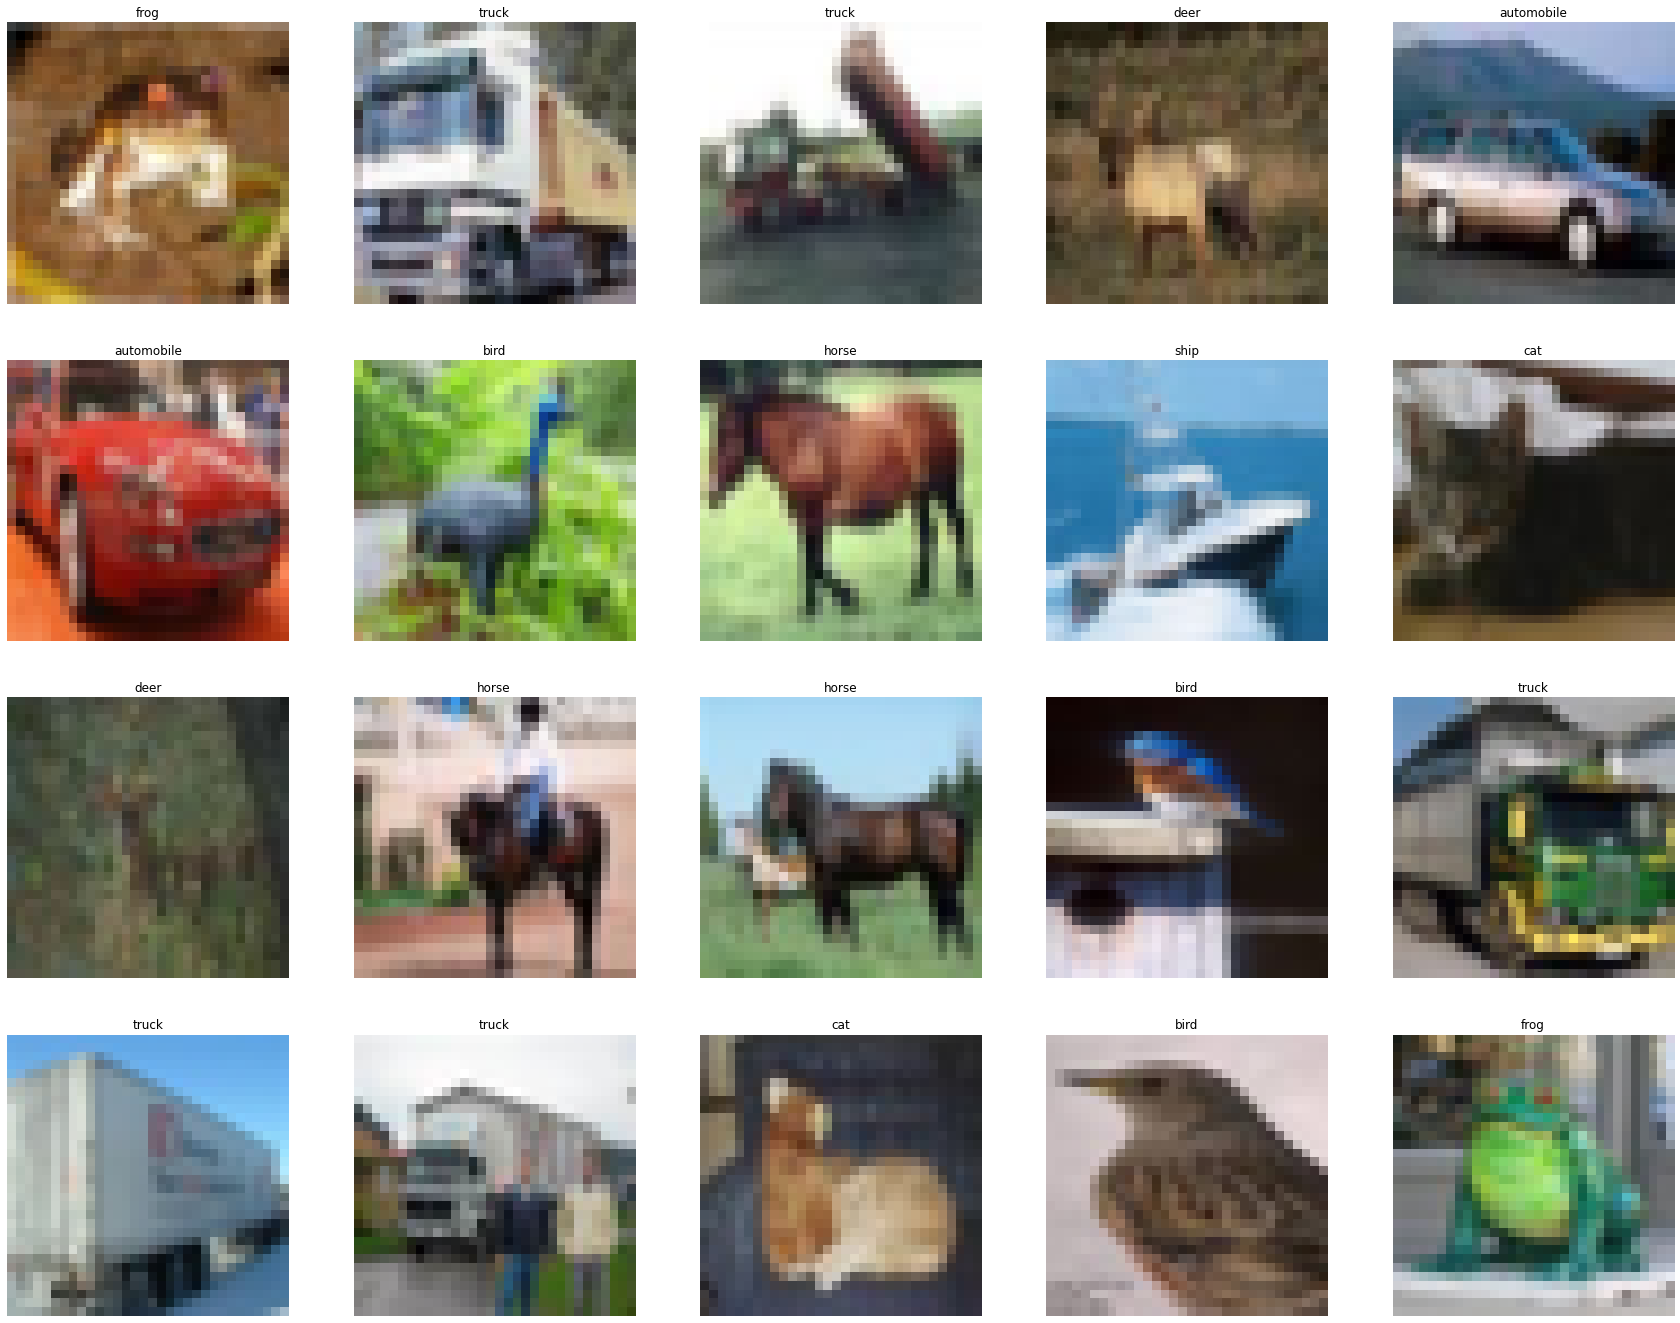

In [23]:
plt.figure(figsize=(30,30))
for i,(image,label) in enumerate(train_ds.take(20)):
    #print(label)
    ax=plt.subplot(5,5,i+1)
    plt.imshow(image)
    plt.title(CLASS_NAMES[label.numpy()[0]])
    plt.axis('off')

In [33]:
def process_image(image,label):
    image=tf.image.per_image_standardization(image)
    image=tf.image.resize(image,(64,64))
    
    return image,label

# Data Pipeline


So far, we have obtained and partitioned the dataset and created a function to process the dataset. The next step is to build an input pipeline.

An input/data pipeline is described as a series of functions or methods that are called consecutively one after another.

Input pipelines are a chain of functions that either act upon the data or enforces an operation on the data flowing through the pipeline.

In [29]:
train_ds_size=tf.data.experimental.cardinality(train_ds).numpy()
test_ds_size=tf.data.experimental.cardinality(test_ds).numpy()
print('Train size:',train_ds_size)
print('Test size:',test_ds_size)

Train size: 1562
Test size: 312


For our basic input/data pipeline, we will conduct three primary operations:
1. Preprocessing the data within the dataset
2. Shuffle the dataset
3. Batch data within the dataset

In [30]:
train_ds=(train_ds
          .map(process_image)
          .shuffle(buffer_size=train_ds_size)
          .batch(batch_size=batch_size,drop_remainder=True)
         )
test_ds=(test_ds
          .map(process_image)
          .shuffle(buffer_size=test_ds_size)
          .batch(batch_size=batch_size,drop_remainder=True)
         )

# Model Implementation
Within this section, we will implement the AlexNet CNN architecture from scratch. Through the utilization of Keras Sequential API, we can implement consecutive neural network layers within our models that are stacked against each other.

Here are the types of layers the AlexNet CNN architecture is composed of, along with a brief description:

### Convolutional layer:
A convolution is a mathematical term that describes a dot product multiplication between two sets of elements. Within deep learning the convolution operation acts on the filters/kernels and image data array within the convolutional layer. Therefore a convolutional layer is simply a layer the houses the convolution operation that occurs between the filters and the images passed through a convolutional neural network.

### Batch Normalisation layer:
Batch Normalization is a technique that mitigates the effect of unstable gradients within a neural network through the introduction of an additional layer that performs operations on the inputs from the previous layer. The operations standardize and normalize the input values, after that the input values are transformed through scaling and shifting operations.

### MaxPooling layer:
Max pooling is a variant of sub-sampling where the maximum pixel value of pixels that fall within the receptive field of a unit within a sub-sampling layer is taken as the output. The max-pooling operation below has a window of 2x2 and slides across the input data, outputting an average of the pixels within the receptive field of the kernel.

### Flatten layer:
Takes an input shape and flattens the input image data into a one-dimensional array.

### Dense Layer:
A dense layer has an embedded number of arbitrary units/neurons within. Each neuron is a perceptron.

The code snippet represents the Keras implementation of the AlexNet CNN architecture.

In [32]:
model=keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(64,64,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3)),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10,activation='softmax')   
])

# Training and Results
To train the network, we have to compile it.

The compilation processes involve specifying the following items:

### Loss function:
A method that quantifies ‘how well’ a machine learning model performs. The quantification is an output(cost) based on a set of inputs, which are referred to as parameter values. The parameter values are used to estimate a prediction, and the ‘loss’ is the difference between the predictions and the actual values.

### Optimization Algorithm:
An optimizer within a neural network is an algorithmic implementation that facilitates the process of gradient descent within a neural network by minimizing the loss values provided via the loss function. To reduce the loss, it is paramount the values of the weights within the network are selected appropriately.

### Learning Rate:
An integral component of a neural network implementation detail as it’s a factor value that determines the level of updates that are made to the values of the weights of the network. Learning rate is a type of hyperparameter.

We can also provide a summary of the network to have more insight into the layer composition of the network by running the model.summary() function.

In [32]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.optimizers.SGD(lr=0.001),
    metrics=['accuracy']    
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 128)       46592     
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 128)       512       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 256)         819456    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 256)         1024      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 256)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 256)        

At this point, we are ready to train the network.

Training the custom AlexNet network is very simple with the Keras module enabled through TensorFlow. We simply have to call the fit() method and pass relevant arguments.

Epoch: This is a numeric value that indicates the number of time a network has been exposed to all the data points within a training dataset.

In [33]:
history=model.fit(
    train_ds,
    epochs=50,
    validation_data=test_ds,
    validation_freq=1
)

Epoch 1/50
1562/1562 [==============================] - 33s 14ms/step - loss: 2.4591 - accuracy: 0.1878 - val_loss: 1.6988 - val_accuracy: 0.3925
Epoch 2/50
1562/1562 [==============================] - 31s 14ms/step - loss: 1.8495 - accuracy: 0.3324 - val_loss: 1.5596 - val_accuracy: 0.4362
Epoch 3/50
1562/1562 [==============================] - 31s 13ms/step - loss: 1.6832 - accuracy: 0.3896 - val_loss: 1.4645 - val_accuracy: 0.4771
Epoch 4/50
1562/1562 [==============================] - 32s 14ms/step - loss: 1.5484 - accuracy: 0.4411 - val_loss: 1.3894 - val_accuracy: 0.5078
Epoch 5/50
1562/1562 [==============================] - 31s 14ms/step - loss: 1.4537 - accuracy: 0.4763 - val_loss: 1.3526 - val_accuracy: 0.5226
Epoch 6/50
1562/1562 [==============================] - 30s 14ms/step - loss: 1.3658 - accuracy: 0.5103 - val_loss: 1.3062 - val_accuracy: 0.5372
Epoch 7/50
1562/1562 [==============================] - 31s 13ms/step - loss: 1.2952 - accuracy: 0.5403 - val_loss: 1.2378 -

In [34]:
import time
import os
import copy
import csv
import pandas as pd
from datetime import datetime

In [38]:
def export_history_csv(history_, model_name):
  since = time.time()
  date = datetime.today().strftime('%Y-%m-%d-%H:%M:%S')
  data_file = open('./data/23-08-2021/tf_exp_train_{}_{}.csv'.format(model_name, date), mode='w+', newline='', encoding='utf-8')
  data_writer = csv.writer(data_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
  data_writer.writerow(['Model','type', 'Dataset', 'Epoch', 'criterion', 'optimizer', 'scheduler','Train_loss', 'Train_acc', "val_loss", "Val_acc", 'time','Elapse_time','date'])
  for epoch_ in history_.epoch:
    data_writer.writerow([history_.model,'tensorflow', 'hymenoptera', epoch_, '', 
                          history_.model.optimizer, '',history_.history['loss'][epoch_], history_.history['accuracy'][epoch_], 
                          history_.history['val_loss'][epoch_], history_.history['val_accuracy'][epoch_], '','',date])
  data_file.close()

In [39]:
export_history_csv(history, 'Alexnet-cifar10')

In [37]:
date = datetime.today().strftime('%Y-%m-%d-%H:%M:%S')
model.save("./data/23-08-2021/tf_alexnet_cifar10_{}.h5".format(date))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 128)       46592     
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 128)       512       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 256)         819456    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 256)         1024      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 256)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 256)        

In [40]:
model.history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Now we will visualize the training over the different epochs .

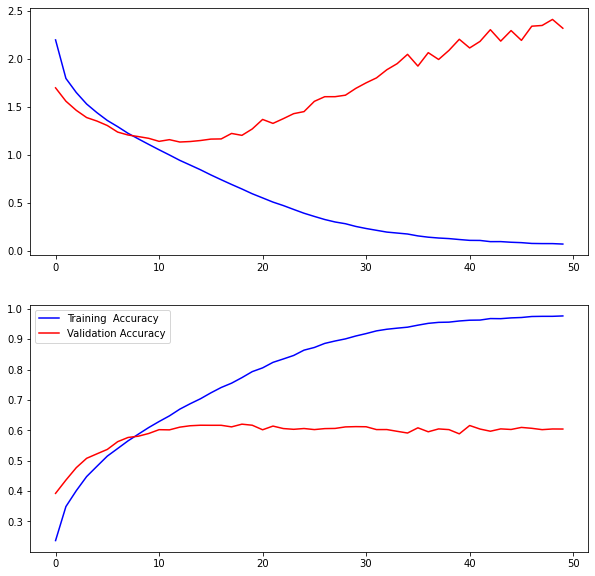

In [41]:
f,ax=plt.subplots(2,1,figsize=(10,10)) 

#Assigning the first subplot to graph training loss and validation loss
ax[0].plot(model.history.history['loss'],color='b',label='Training Loss')
ax[0].plot(model.history.history['val_loss'],color='r',label='Validation Loss')

#Plotting the training accuracy and validation accuracy
ax[1].plot(model.history.history['accuracy'],color='b',label='Training  Accuracy')
ax[1].plot(model.history.history['val_accuracy'],color='r',label='Validation Accuracy')

plt.legend()

# Densnet Keras

In [50]:
import numpy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D
#from tensorflow.keras.constraints import maxnorm
from tensorflow.keras.optimizers import SGD
#from tensorflow.keras.utils import np_utils 
from tensorflow.keras import backend as K 
import tensorflow
#K.set_image_dim_ordering('tf')

In [46]:
from keras.datasets import cifar10
# let's load data 
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

### Normalization and One-Hot Encoding

Images are comprised of matrices of pixel values. Normally, pixels are expected to have value in the range 0-255. We need to normalize these values to a range between 0 and 1.

In [47]:
#normalizing inputs from 0-255 to 0.0-1.0 
X_train = X_train.astype('float32') 
X_test = X_test.astype('float32') 
X_train = X_train / 255.0 
X_test = X_test / 255.0

Now, we need to do one-hot encoding of these data so that it could be provided to machine learning algorithms to do a better job in prediction. One-hot is a group of bits among which the legal combinations of values are only those with a single high bit and all the others low. 

In [51]:
# one hot encode outputs 
y_train = tensorflow.keras.utils.to_categorical(y_train) 
y_test = tensorflow.keras.utils.to_categorical(y_test) 
num_classes = y_test.shape[1]

his will convert the matrices into binary matrices of width 10. We can’t just give the categorical data to the machine for processing. So, we need to do the above steps to make the data more processable for the machine.

## Creating the Image Classification Model

Let’s initialize a convolutional neural network using the sequential model of keras.

In [52]:
# Create the model 
model = Sequential()

You can use either Sequential or Functional methods for creating keras models. We are using sequential here to build our model since it allows us to create the model layer-by-layer.

Now, we are going to add all the layers required for our convolutional neural network.

In [54]:
model.add(Conv2D(32, (3, 3), input_shape=(32,32,3), activation='relu', padding='same')) 
model.add(Dropout(0.2)) 
model.add(Conv2D(32, (3, 3), activation='relu', padding='same')) 
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Conv2D(64, (3, 3), activation='relu', padding='same')) 
model.add(Dropout(0.2)) 
model.add(Conv2D(64, (3, 3), activation='relu', padding='same')) 
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Conv2D(128, (3, 3), activation='relu', padding='same')) 
model.add(Dropout(0.2)) 
model.add(Conv2D(128, (3, 3), activation='relu', padding='same')) 
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Flatten()) 
model.add(Dropout(0.2)) 
model.add(Dense(1024, activation='relu', kernel_constraint=maxnorm(3))) 
model.add(Dropout(0.2)) 
model.add(Dense(512, activation='relu', kernel_constraint=maxnorm(3))) 
model.add(Dropout(0.2)) 
model.add(Dense(num_classes, activation='softmax'))

NameError: name 'maxnorm' is not defined